## Chapter 5: Zero order methods

# 5.5  Coordinate search and descent

The coordinate search and descent algorithms are additional zero order local methods that get around the inherent scaling issues of random local search by restricting the set of search directions to the coordinate axes of the input space.  The concept is simple: random search was designed to minimize a function $g\left(w_1,w_2,...,w_N\right)$ with respect to all of its parameters *simultaneously*.  With coordinate wise algorithms we attempt to minimize such a function with respect to one coordinate or weight at a time - or more generally one subset of coordinates or weights at a time - keeping all others fixed.

While this limits the diversity of descent directions that can be potentially discovered, and thus more steps are often required to determine approximate minima, these algorithms are far more scalable than random search (so much so that they can indeed be effectively used in practice with modern machine learning problems).  Additionally  - as was the case with the random search approach - these algorithms serve as predicates for an entire thread of higher order *coordinate descent methods* we will see in the next few Chapters.  Through understanding coordinate search / descent in the comparatively simpler zero order framework we are currently in we lay the ground work for better understanding of this entire suite of powerful coordinate-based algorithms.

In [83]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
import numpy as np
from datetime import datetime 
static_plotter = optlib.static_plotter.Visualizer();
optimizers = optlib.optimizers

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

## 5.5.1  Searching through the coordinate axes

The *coordinate search* algorithm takes the theme of descent direction search and - instead of searching randomly - restricts the set of directions to the coordinate axes of the input space alone.  While this significantly limits the kinds of descent directions we can recover it far more scalable than seeking out a good descent direction at random, and 
opens the search-approach to determining descent directions to usage with higher dimensional input functions.

As illustrated in the Figure below for an $N$ = 2 dimensional example, with coordinate search we seek out the best descent direction among only the coordinate axes of the input space.  This means in general that for a function of input dimension $N$ we only look over $2N$ directions - the positive and negative versions of each coordinate input.  As with the random local search algorithm we will use unit-length directions, meaning that at every step the set of directions we search over always consists of just positive and negative versions of the *standard basis*.  

<< FIGURE OF QUADRATC CONTOURS WITH STANDARD BASIS SEARCH DIRECTIONS AT A POINT>>

In an $N$ dimensional input space the $n^{th}$ standard basis vector - denoted $\mathbf{e}_n$ -  is just a vector of all zeros whose $n^{th}$ entry is set to $1$.  Searching only over the positive and negative set of these directions means at the $k^{th}$ step of this local method we search only over the set of $2N$ candidate directions $\left\{\pm \, \mathbf{e}_n \right\}_{n=1}^N$ for the best descent direction (if one exists).  This means - in particular - each pair of candidate points using a single standard basis direction looks like

\begin{equation}
\mathbf{w}_{\text{candidate}} = \mathbf{w}^{k-1} \pm \alpha \mathbf{e}_n.
\end{equation}

It is this restricted set of directions we are searching over that distingiushes the coordinate search approach from the random search approach described in the previous Section, where the set of directions at each step was made up of random directions.  While the diversity of the coordinate axes may limit the effectiveness of the possible descent directions it can encounter and thus require more steps to determine an approximate minimum, the restricted search makes coordinate search far more scalable than the random search method since at each step only $2N$ directions must be tested.

Below we provide both pseudo-code and an implementation of coordinate search, followed by several examples employing it.

### Coordinate search algorithm

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> initial point $\mathbf{w}^0$, maximum number of steps $K$, a steplength $\alpha$ or diminishing steplength rule, take the  set of directions $\mathbf{d}^{2n - 1} = \mathbf{e}_n$ and  $\mathbf{d}^{2n} = -\mathbf{e}_n$ for $n=1,...,N$ and set $P = 2N$
<br>


<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,k = 1...K$<br>


<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; find $s = \underset{p=1...P}{\text{argmin}}\,\,g\left(\mathbf{w}^{k-1} + \alpha \mathbf{d}^p\right)$<br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; set $\mathbf{d}^{k} = \mathbf{d}^{s}$<br>


<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; form new point $\mathbf{w}^k = \mathbf{w}^{k-1} + \alpha\mathbf{d}^k$ <br>


<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>if</code> $g\left(\mathbf{w}^k\right) < g\left(\mathbf{w}^{k-1}\right)$  <br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mathbf{w}^{k-1} \longleftarrow \mathbf{w}^{k}$<br>



<strong>9:</strong>&nbsp;&nbsp; <strong>output:</strong> history of weights $\left\{\mathbf{w}^{k}\right\}_{k=0}^K$ and corresponding function evaluations $\left\{g\left(\mathbf{w}^{k}\right)\right\}_{k=0}^K$ <br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

In [67]:
# zero order coordinate search
def coordinate_search(g,alpha_choice,max_its,w):
    # construct set of all coordinate directions
    directions_plus = np.eye(np.size(w),np.size(w))
    directions_minus = - np.eye(np.size(w),np.size(w))
    directions = np.concatenate((directions_plus,directions_minus),axis=0)
        
    # run coordinate search
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
            
        # record weights and cost evaluation
        weight_history.append(w)
        cost_history.append(g(w))
        
        ### pick best descent direction
        # compute all new candidate points
        w_candidates = w + alpha*directions
        
        # evaluate all candidates
        evals = np.array([g(w_val) for w_val in w_candidates])

        # if we find a real descent direction take the step in its direction
        ind = np.argmin(evals)
        if g(w_candidates[ind]) < g(w):
            # pluck out best descent direction
            d = directions[ind,:]
        
            # take step
            w = w + alpha*d
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

#### <span style="color:#a50e3e;">Example 1. </span>  Coordinate search applied to minimize a simple quadratic

In the next Python cell we compare 5 steps of the random search algorithm (with $P = 1000$ random directions tested at each step) to 7 steps of coordinate search, using the same starting point $\mathbf{w}^0 = \begin{bmatrix}3 \\ 4\end{bmatrix}$ and fixed steplength parameter value $\alpha = 1$ for both.  The test function in this case is the simple quadratic used in several of the examples of the previous Section

\begin{equation}
g(w_0,w_1) = w_0^2 + w_1^2 + 2.
\end{equation}

The resulting steps taken by random search are shown on the function contour in the left panel, and likewise for coordinate search in the right panel.  Both algorithms reach the global mininimum of the function at the origin, but it takes coordinate search a few more steps to do so (due to the vastly fewer directions it searches over when compared to random search).  Notice as well how the steps of coordinate descent tend to zig-zag towards the solution.  This is again due to the fact that it only looks over the two perpendicular directions provided by the axes when deciding on a direction for each step.

<IPython.core.display.Javascript object>


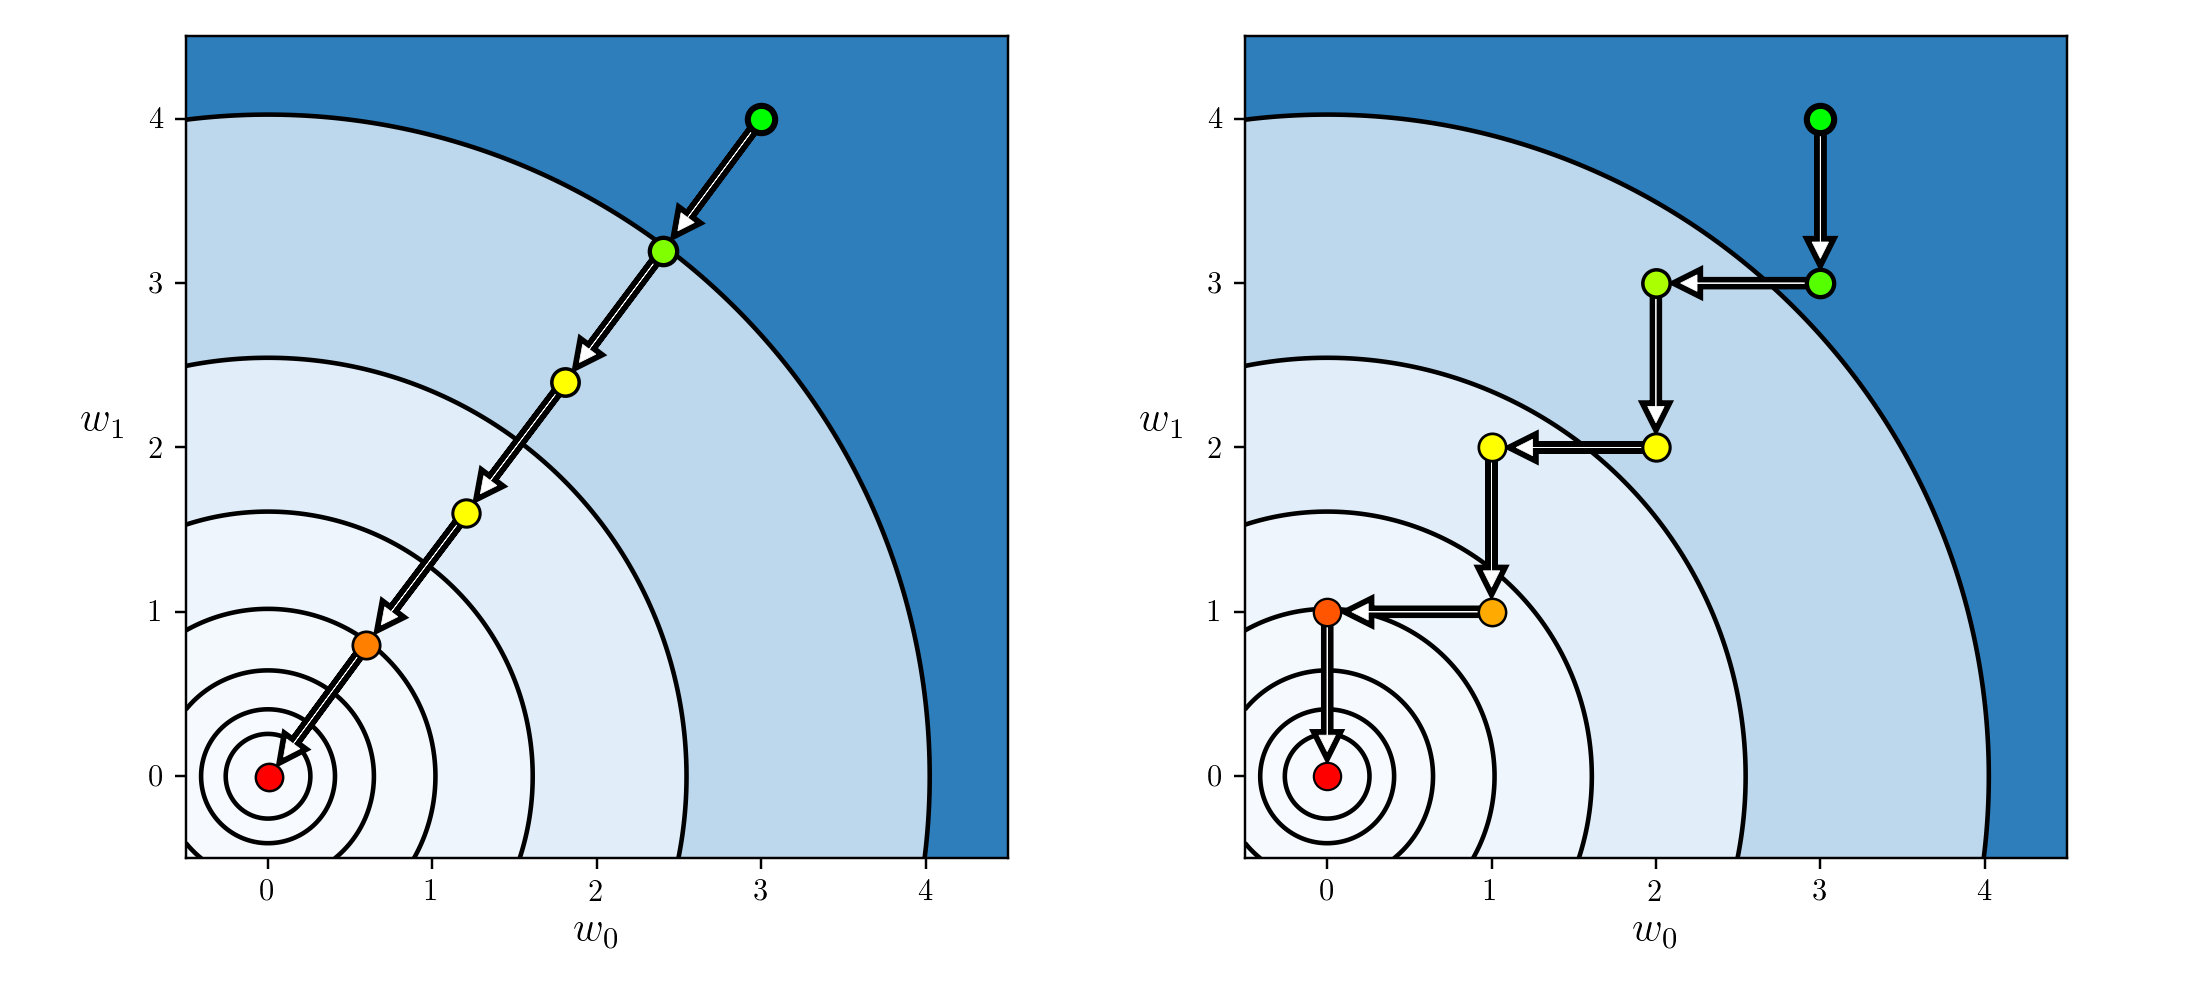

In [82]:
# define function
g = lambda w: np.dot(w.T,w) + 2

# run random search algorithm 
alpha_choice = 1; w = np.array([3,4]); num_samples = 1000; max_its = 5;
weight_history_1,cost_history_1 = optimizers.random_search(g,alpha_choice,max_its,w,num_samples)

# run coordinate search algorithm 
alpha_choice = 1; w = np.array([3,4]); max_its = 7;
weight_history_2,cost_history_2 = coordinate_search(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.compare_runs_contour_plots(g,[weight_history_1,weight_history_2],xmin = -0.5,xmax = 4.5,ymin = -0.5,ymax = 4.5,num_contours = 7)

---

Note however that while it may take the coordinate search method more steps to reach the mininum of this particular function, it is still far more computationally effecient than the random search run shown above.  This is because - when it comes down to the cost per step of each algorithm 

- with coordinate search: checking the positive and negative directions along the coordinate axes in $N$ dimensional space costs essentially $2N$ function evaluations (one per direction)


- with random search: checking $P$ random directions essentially costs $P$ function evaluations per step (again, one per direction)

Below we repeat the experiment above and time each run.  For the specific settings shown here the coordinate search run is far faster.

In [35]:
# define function
g = lambda w: np.dot(w.T,w) + 2

### time the run of random search
start_time = datetime.now() 

# run random search algorithm 
alpha_choice = 1; w = np.array([3,4]); num_samples = 1000; max_its = 5;
weight_history_1,cost_history_1 = optimizers.random_search(g,alpha_choice,max_its,w,num_samples)

time_elapsed = datetime.now() - start_time 
print('Time elapsed for random search run (hh:mm:ss.ms) {}'.format(time_elapsed))

### time the run of coordinate search
start_time = datetime.now() 

# run coordinate search algorithm 
alpha_choice = 1; w = np.array([3,4]); max_its = 7;
weight_history_2,cost_history_2 = coordinate_search(g,alpha_choice,max_its,w)

time_elapsed = datetime.now() - start_time 
print('Time elapsed for coordinate seach run (hh:mm:ss.ms) {}'.format(time_elapsed))

Time elapsed for random search run (hh:mm:ss.ms) 0:00:00.033877
Time elapsed for coordinate seach run (hh:mm:ss.ms) 0:00:00.000781


#### <span style="color:#a50e3e;">Example 1. </span>  Coordinate search is a local optimization method, and so we still must properly set the steplength parameter    

In the next Python cell we compare 5 steps of the random search algorithm (with $P = 1000$ random directions tested at each step) to 5 steps of coordinate search, using the same starting point $\mathbf{w}^0 = \begin{bmatrix}3 \\ 4\end{bmatrix}$ and fixed steplength parameter value $\alpha = 1$ for both.  The test function in this case is a skewed quadratic function

\begin{equation}
g(w_0,w_1) = 0.26\left(w_0^2 + w_1^2\right) - 0.48w_0w_1
\end{equation}

The resulting steps taken by random search are shown on the function contour in the left panel, and likewise for coordinate search in the right panel.  Here while the random search algorithm finds the true minimum at the origin, the coordinate search run halts after the first step due to the steplength being set too large for this particular function / initialization (each of the four coordinate directions are directions of *ascent* at the first step).

<IPython.core.display.Javascript object>


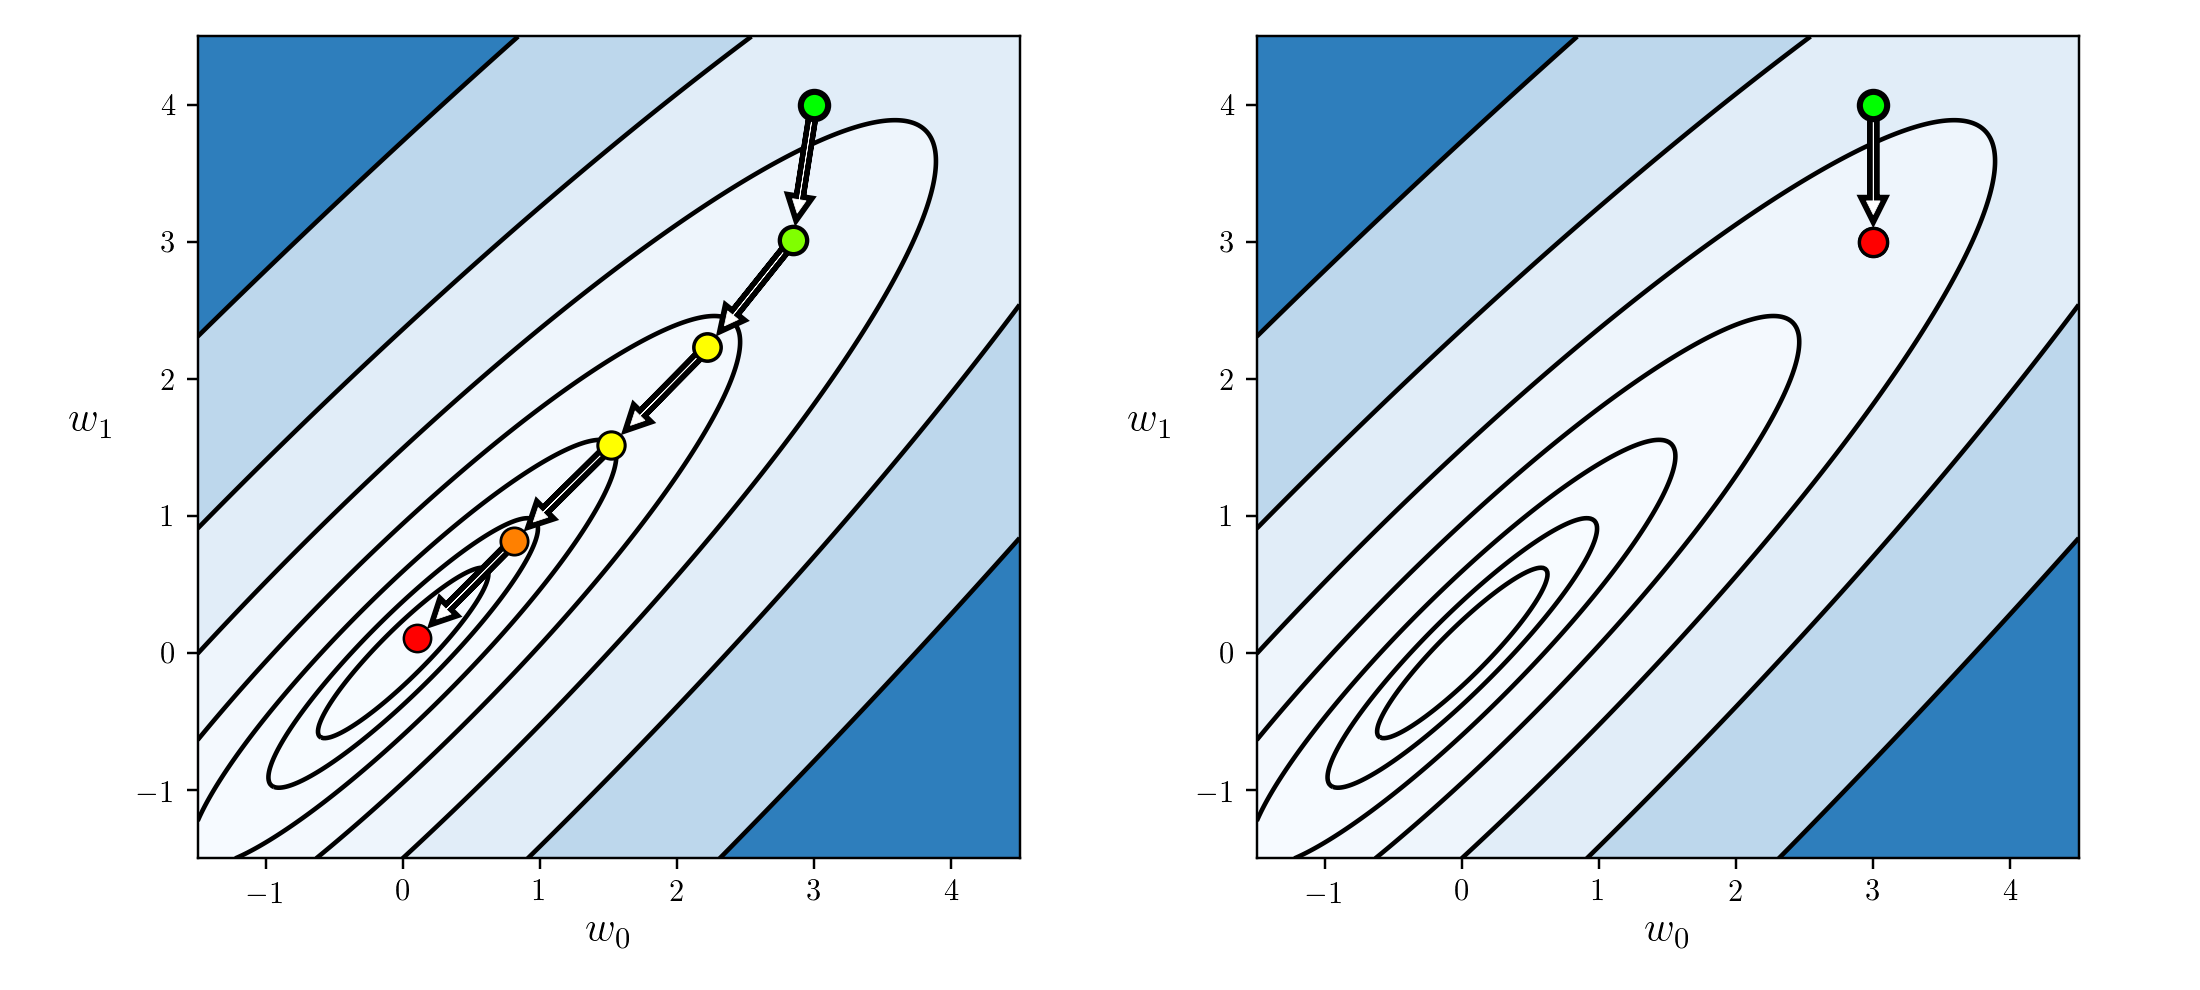

In [20]:
# define function
g = lambda w: 0.26*(w[0]**2 + w[1]**2) - 0.48*w[0]*w[1]

# run random search algorithm 
alpha_choice = 1; w = np.array([3,4]); num_samples = 1000; max_its = 5;
weight_history_1,cost_history_1 = optimizers.random_search(g,alpha_choice,max_its,w,num_samples)

# run coordinate search algorithm 
alpha_choice = 1; w = np.array([3,4]); max_its = 5;
weight_history_2,cost_history_2 = coordinate_search(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.compare_runs_contour_plots(g,[weight_history_1,weight_history_2],xmin = -1.5,xmax = 4.5,ymin = -1.5,ymax = 4.5,num_contours = 7)

By making the steplength parameter smaller we can encourage coordinate search to find its way towards the function's mininum at the origin.  Below we re-run coordinate search using a diminishing steplenght parameter $\alpha = \frac{1}{k}$ at the $k^{th}$ step for $1000$ steps.  With this run the method gets much closer to the function mininum.  Furthermore, even though we used $1000$ steps this run takes fewer total function evaluations - and hence total computation - then the correspnding random search run shown above (for the simple reason discussed in the previous example).

<IPython.core.display.Javascript object>


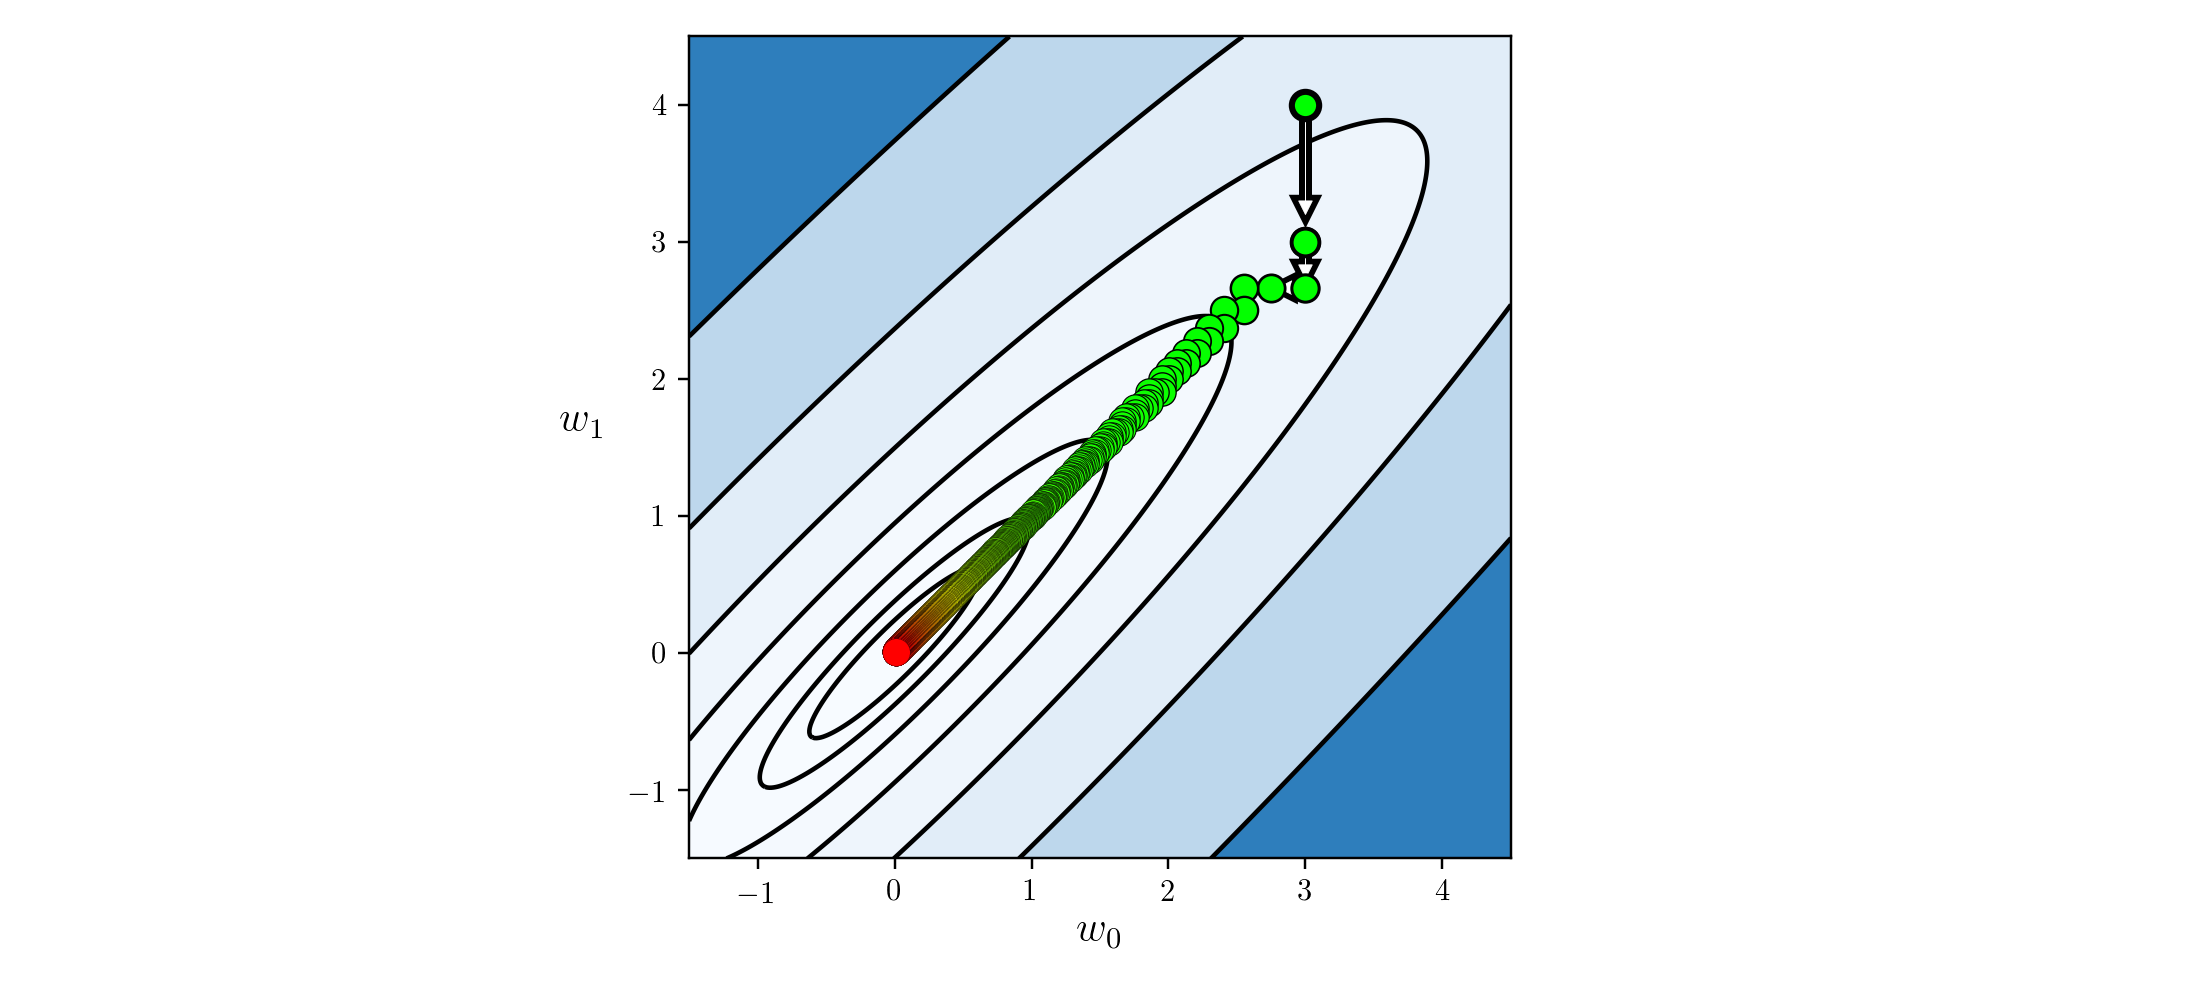

In [30]:
# define function
g = lambda w: 0.26*(w[0]**2 + w[1]**2) - 0.48*w[0]*w[1]

# run coordinate search algorithm 
alpha_choice = 'diminishing'; w = np.array([3,4]); max_its = 1000;
weight_history,cost_history = coordinate_search(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -1.5,xmax = 4.5,ymin = -1.5,ymax = 4.5,num_contours = 7,show_original = False)

## 5.5.2  Zero-order coordinate descent

A slight twist on the coordinate search produces a much more effective algorithm at precisely the same computational cost.  Instead of collecting each coordinate direction (along with its negative), and then choosing a single best direction from this entire set, we can simply examine one coordinate direction (and its negative) at a time and step in this direction if it produces descent.  Whereas with coordinate search we evaluate the cost function $2N$ times (once per coordinate direction and its negative) to produce a single step, this alternative takes the same number of function evaluations but potentially moves $N$ steps in doing so.  In other words this means that for precisely the same cost as coordinate search we can (potentially) descent much faster with coordinate descent.

<< FIGURE OF QUADRATC CONTOURS WITH STANDARD BASIS SEARCH DIRECTIONS AT A POINT>>

This twist on the coordinate search approach is called a *coordinate descent*, since each step evaluates a single coordinate direction and decides whether or not to move in this direction alone.  This particular algorithm - while itself being the most effective zero order method we have seen thus far by far - is a predicate for many useful coordinate descent approaches we will see in future Chapters as well.

We write both pseudocode and a ``Python`` implementation of this approach below, followed by an example.

### Coordinate descent algorithm (zero-order)

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> initial point $\mathbf{w}^0$, maximum number of steps $K$, a steplength $\alpha$ or diminishing steplength rule
<br>


<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,k = 1...K$<br>


<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $n=1,...,N$ <br>


<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; find $s = \underset{\,}{\text{argmin}}\,\,\left\{g\left(\mathbf{w}^{k + n-1} + \alpha \mathbf{e}_n\right),\,g\left(\mathbf{w}^{k + n-1} - \alpha \mathbf{e}_n\right)\right\}$<br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; set $\mathbf{d}^{k + n} = \left(-1\right)^{s}\mathbf{e}_n$<br>


<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; form new point $\mathbf{w}^{k + n} = \mathbf{w}^{k + n-1} + \alpha\mathbf{d}^{k + n}$ <br>


<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>if</code> $g\left(\mathbf{w}^{k + n}\right) < g\left(\mathbf{w}^{k + n-1}\right)$  <br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mathbf{w}^{k + n-1} \longleftarrow \mathbf{w}^{k + n}$<br>

<strong>9:</strong>&nbsp;&nbsp; <strong>output:</strong> history of weights $\left\{\mathbf{w}^{b}\right\}_{b=0}^{KN}$ and corresponding function evaluations $\left\{g\left(\mathbf{w}^{b}\right)\right\}_{b=0}^{KN}$ <br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

In [53]:
# zero order coordinate search
def coordinate_descent_zero_order(g,alpha_choice,max_its,w):  
    # run coordinate search
    N = np.size(w)
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # random shuffle of coordinates
        c = np.random.permutation(N)
        
        # forming the dirction matrix out of the loop
        DIRECTION = np.eye(N)
        cost = g(w)
        
        # loop over each coordinate direction
        for n in range(N):
            #direction = np.zeros((N,1))
            #direction[c[n]] = 1
            direction = DIRECTION[:,[c[n]]]
     
            # record weights and cost evaluation
            weight_history.append(w)
            cost_history.append(cost)

            # evaluate all candidates
            evals =  [g(w + alpha*direction)]
            evals.append(g(w - alpha*direction))
            evals = np.array(evals)

            # if we find a real descent direction take the step in its direction
            ind = np.argmin(evals)
            if evals[ind] < cost_history[-1]:
                # take step
                w = w + ((-1)**(ind))*alpha*direction
                cost = evals[ind]
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

#### <span style="color:#a50e3e;">Example 2. </span>  Coordinate search versus coordinate descent

In this example we compare the effecacy of coordinate search and the coordinate descent algorithm described above using the same function from the previous example.  Here we compare $20$ steps of coordinate search (left panel) and coordinate descent (right panel), using a diminishing step length for both runs.  Because coordinate descent takes two steps for every single step taken by coordinate search we get significantly closer to the function minimum.

<IPython.core.display.Javascript object>


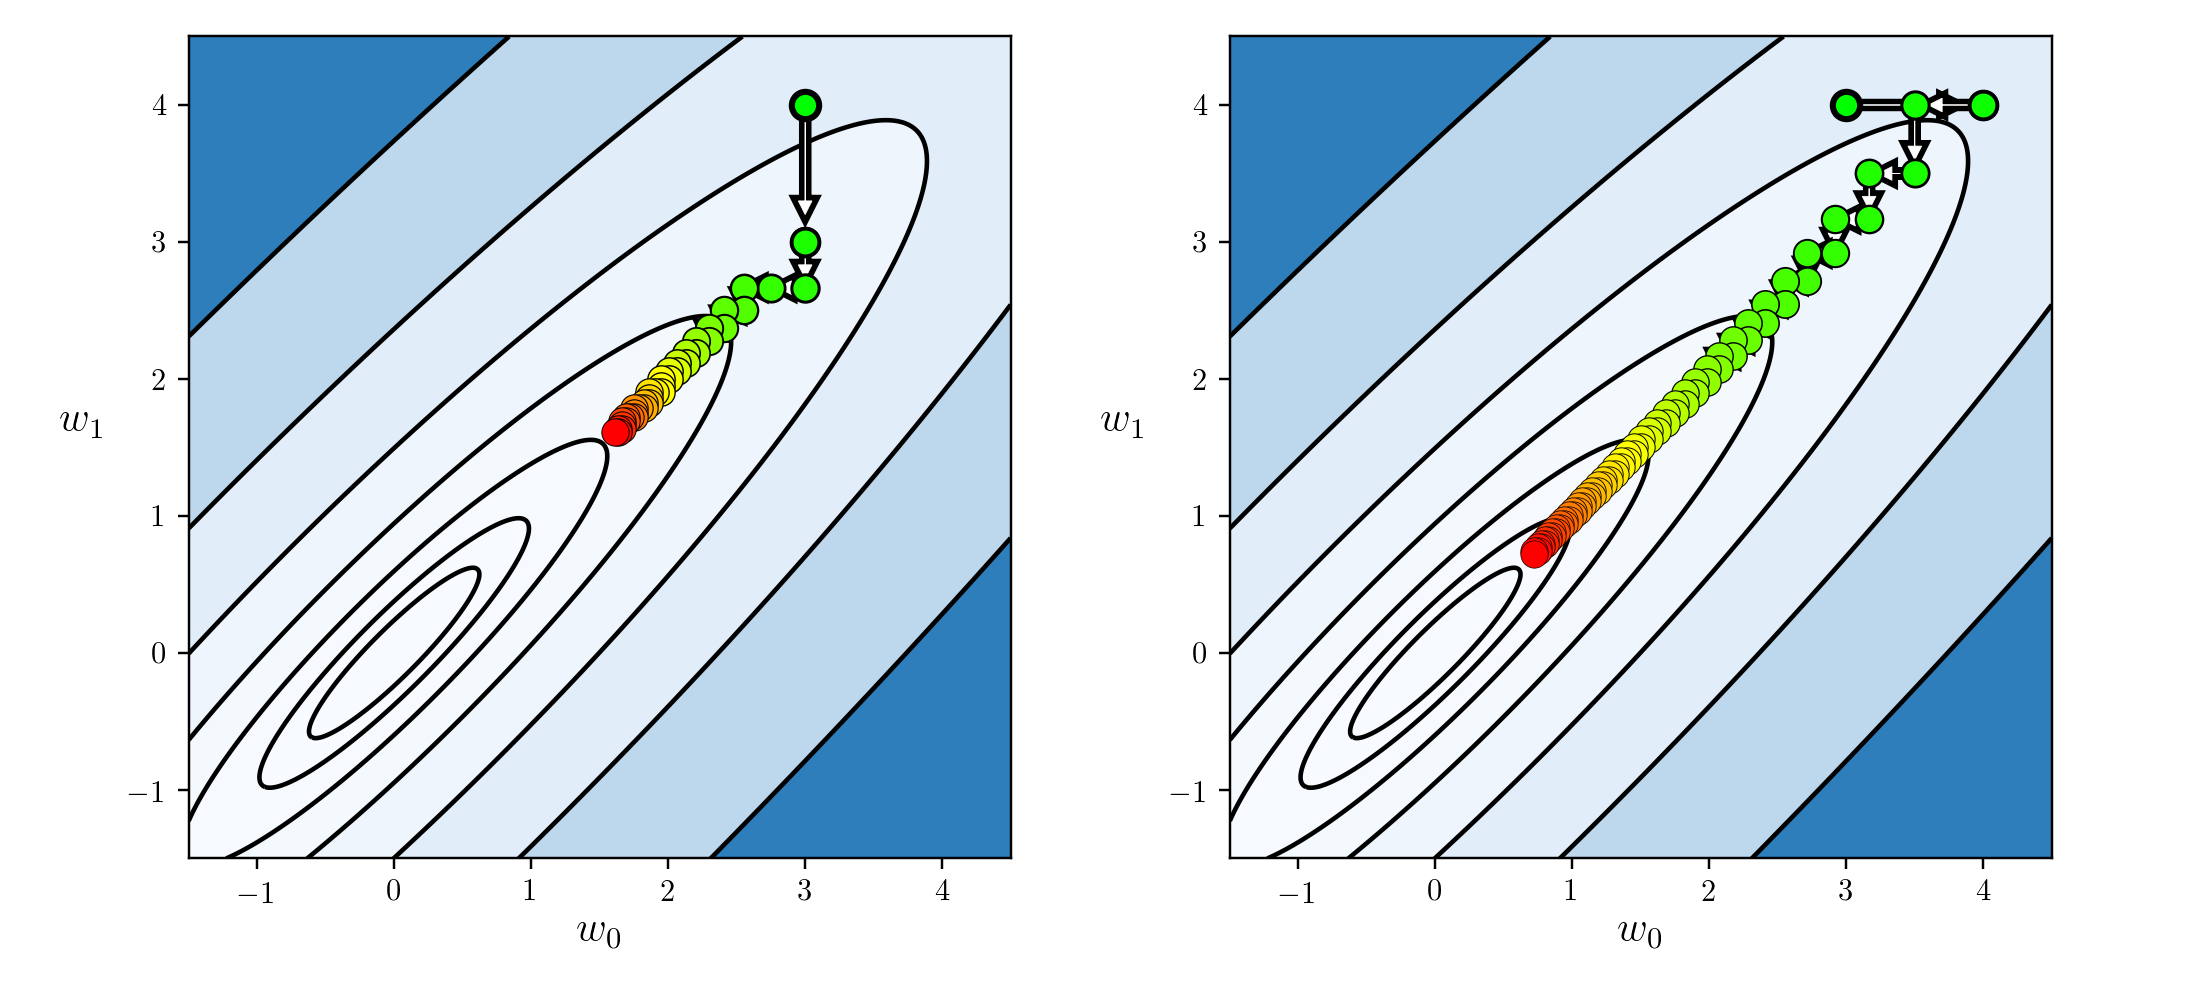

In [64]:
# define function
g = lambda w: 0.26*(w[0]**2 + w[1]**2) - 0.48*w[0]*w[1]

# run coordinate search algorithm 
alpha_choice = 'diminishing'; w = np.array([3,4]); max_its = 40;
weight_history_1,cost_history_1 = coordinate_search(g,alpha_choice,max_its,w)

# run coordinate descent algorithm
alpha_choice = 'diminishing'; w = np.array([3,4]); max_its = 40;
weight_history_2,cost_history_2 = coordinate_descent_zero_order(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.compare_runs_contour_plots(g,[weight_history_1,weight_history_2],xmin = -1.5,xmax = 4.5,ymin = -1.5,ymax = 4.5,num_contours = 7)

We can view the precise difference more easily by comparing the two function evaluation histories via the cost function history plot, which we do below.  Here we can see in this instance while the first several steps of coordinate search were more effective than their descent counterparts (since they search over the entire list of coordinate directions instead of one at a time), the coordinate descent method quickly overtakes search finding a lower point on the cost function.

<IPython.core.display.Javascript object>


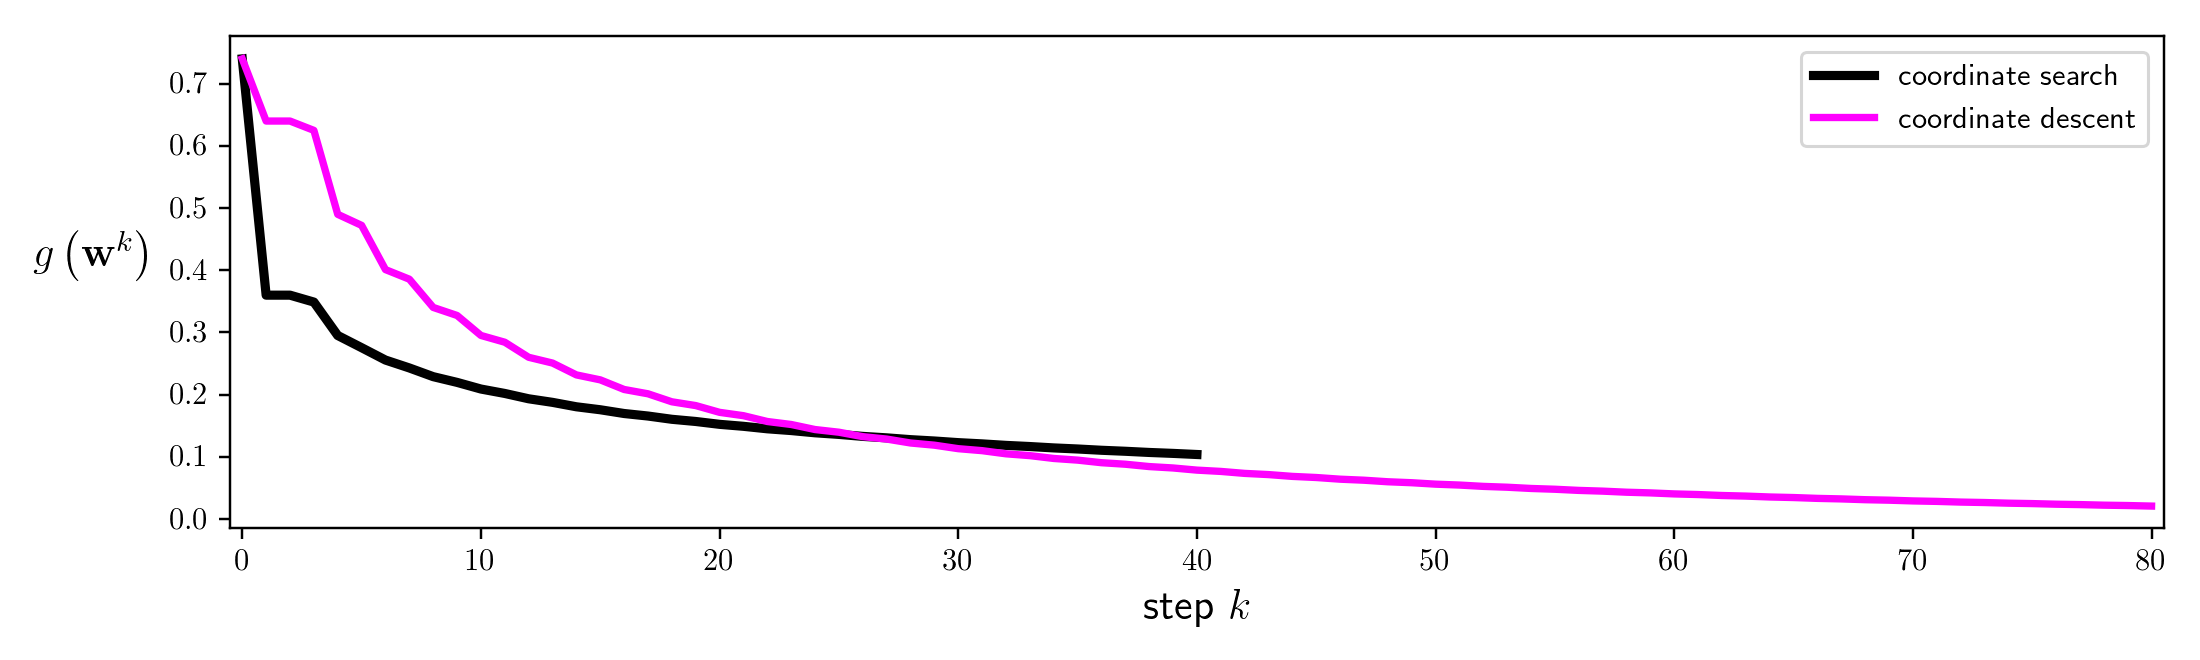

In [65]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = False,labels = ['coordinate search','coordinate descent'])

<IPython.core.display.Javascript object>


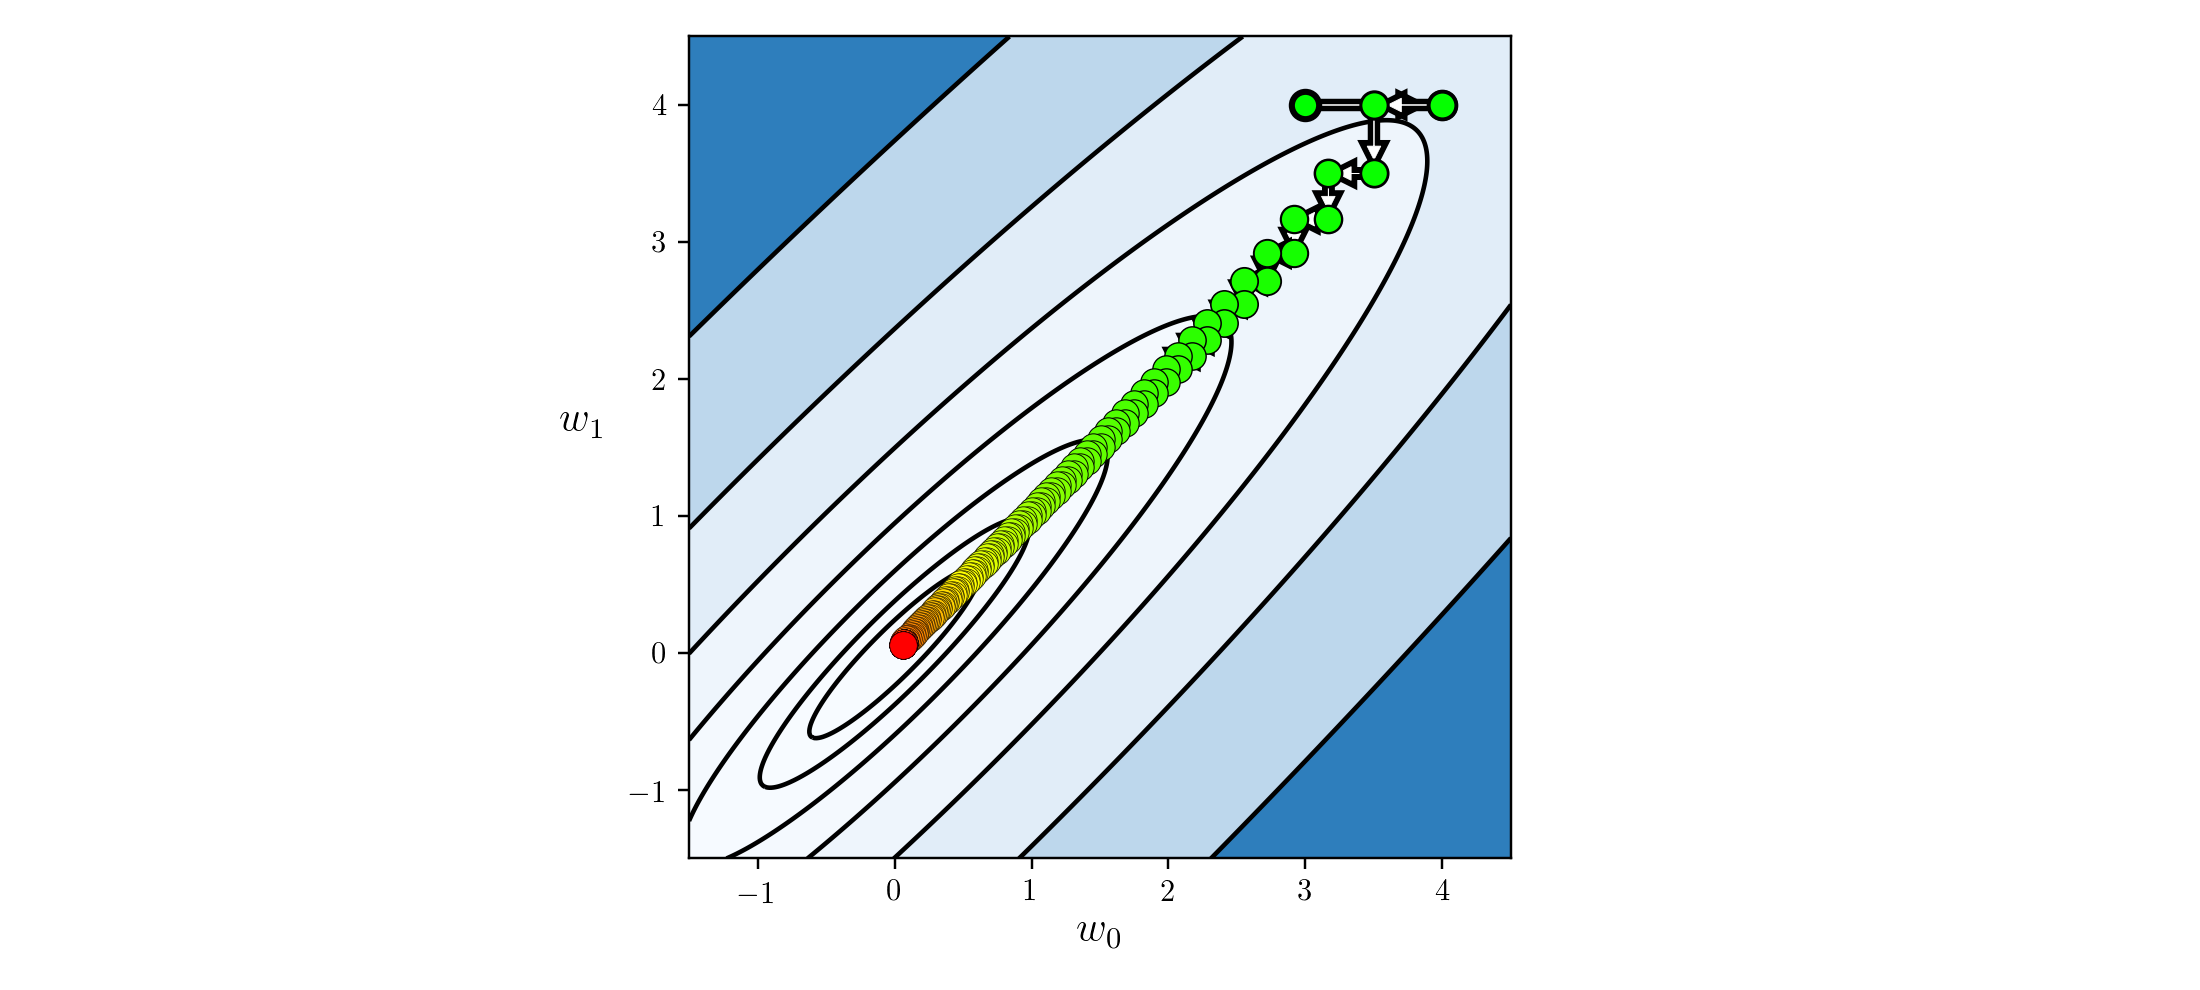

In [57]:
# define function
g = lambda w: 0.26*(w[0]**2 + w[1]**2) - 0.48*w[0]*w[1]

# run coordinate search algorithm 
alpha_choice = 'diminishing'; w = np.array([3,4]); max_its = 100;
weight_history,cost_history = coordinate_descent_zero_order(g,alpha_choice,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -1.5,xmax = 4.5,ymin = -1.5,ymax = 4.5,num_contours = 7,show_original = False)

## 5.5.3  Conclusions

While the directions used by coordinate search are far simpler than those we can potentially find by randomly search, we can often find a descent direction among them that works well enough.  Moreover coordinate search is far more effecient per step than its random counterpart, requiring $2N$ function evaluations per step as compared to a number of random sample directions $P$ which - as we saw in the previous Section - must grow exponentially in $N$ in order for random search to be truly effective.  This is a considerable gain in effeciency, but as we will see starting in the next Chapter we can do even better, much better in fact.